In [1]:
import os
import functools
from itertools import groupby
import operator
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Seq import Seq
from Bio import SeqIO

from dwave.system import LeapHybridCQMSampler
from dimod import Binary, ConstrainedQuadraticModel
import dwave.inspector

from codon_hamiltonian import *

In [6]:
experiments = pd.read_csv('cDNA Construct_output by python_rev1_220704.csv')
experiments

,Protein name,mRNA number,cDNA sequence,Protein sequence,data availability,notes
0,PGEX-NAP2,NM_002704,ATGAGCCTCAGACTTGATACCACCCCTTCCTGTAACAGTGCGAGAC...,MSLRLDTTPSCNSARPLHALQVLLLLSLLLTALASSTKGQTKRNLA...,True,NaN
1,PGEX-TAB2,NM_001292034,ATGGCCCAAGGAAGCCACCAAATTGATTTTCAGGTTTTACATGACC...,MAQGSHQIDFQVLHDLRQKFPEVPEVVVSRCMLQNNNNLDACCAVL...,True,NaN
2,PGEX-TAB2,NM_001292035,NaN,NaN,False,NaN
3,PGEX-JDK-NAP1,NM_001307924,ATGGCAGACATTGACAACAAAGAACAGTCTGAACTTGATCAAGATT...,MADIDNKEQSELDQDLDDVEEVEEEETGEETKLKARQLTVQMMQNP...,True,NaN
4,PGEX-JDK-NAP1,NM_001330231,ATGGCAGACATTGACAACAAAGAACAGTCTGAACTTGATCAAGATT...,MADIDNKEQSELDQDLDDVEEVEEEETGEETKLKARQLTVQMMQNP...,True,NaN
...,...,...,...,...,...,...
284,mMCAM,NM_006500,ATGGGGCTTCCCAGGCTGGTCTGCGCCTTCTTGCTCGCCGCCTGCT...,MGLPRLVCAFLLAACCCCPRVAGVPGEAEQPAPELVEVEVGSTALL...,True,NaN
285,SREBP2(Full),NM_004599,ATGGACGACAGCGGCGAGCTGGGTGGTCTGGAGACCATGGAGACCC...,MDDSGELGGLETMETLTELGDELTLGDIDEMLQFVSNQVGEFPDLF...,True,NaN
286,mIGF1,NM_001111274,ATGACCGCACCTGCAATAAAGATACACATCATGTCGTCTTCACACC...,MTAPAIKIHIMSSSHLFYLALCLLTFTSSTTAGPETLCGAELVDAL...,True,NaN
287,mIGF1,NM_001111275,ATGGGGAAAATCAGCAGCCTTCCAACTCAATTATTTAAGATCTGCC...,MGKISSLPTQLFKICLCDFLKIKIHIMSSSHLFYLALCLLTFTSST...,True,NaN


In [2]:
experiments = pd.read_csv('Optimal codon sequences_output_220817.csv')
experiments

,Unnamed: 0,Protein name,mRNA number,cDNA sequence,Protein sequence,data availability,notes,optimal codon sequence,similarity to original cds,CAI for e.coli,CAI for h.sapiens,CPB for e.coli,CPB for h.sapiens,Effective number of codons,GC,GC3
0,0,PGEX-NAP2,NM_002704,ATGAGCCTCAGACTTGATACCACCCCTTCCTGTAACAGTGCGAGAC...,MSLRLDTTPSCNSARPLHALQVLLLLSLLLTALASSTKGQTKRNLA...,True,NaN,ATGTCGCTGCGTCTGGATACTACACCTTCATGTAATTCTGCACGTC...,0.757812,0.656160,0.780554,0.089301,0.004445,30.214605,52.864583,58.593750
1,1,PGEX-TAB2,NM_001292034,ATGGCCCAAGGAAGCCACCAAATTGATTTTCAGGTTTTACATGACC...,MAQGSHQIDFQVLHDLRQKFPEVPEVVVSRCMLQNNNNLDACCAVL...,True,NaN,ATGGCACAAGGCAGTCATCAGATCGACTTCCAGGTGCTGCATGATC...,0.727273,0.654067,0.787806,0.111784,0.009102,37.755559,52.910053,58.008658
2,2,PGEX-TAB2,NM_001292035,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,PGEX-JDK-NAP1,NM_001307924,ATGGCAGACATTGACAACAAAGAACAGTCTGAACTTGATCAAGATT...,MADIDNKEQSELDQDLDDVEEVEEEETGEETKLKARQLTVQMMQNP...,True,NaN,ATGGCTGACATCGACAACAAGGAGCAGAGCGAGCTGGATCAGGATC...,0.778068,0.679714,0.833929,0.088086,0.007509,34.365433,51.784160,65.274151
4,4,PGEX-JDK-NAP1,NM_001330231,ATGGCAGACATTGACAACAAAGAACAGTCTGAACTTGATCAAGATT...,MADIDNKEQSELDQDLDDVEEVEEEETGEETKLKARQLTVQMMQNP...,True,NaN,ATGGCTGACATCGACAACAAGGAGCAGAGCGAGCTGGATCAGGATC...,0.788576,0.670683,0.820711,0.087190,0.031834,35.546786,50.980392,61.892583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,284,mMCAM,NM_006500,ATGGGGCTTCCCAGGCTGGTCTGCGCCTTCTTGCTCGCCGCCTGCT...,MGLPRLVCAFLLAACCCCPRVAGVPGEAEQPAPELVEVEVGSTALL...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285,285,SREBP2(Full),NM_004599,ATGGACGACAGCGGCGAGCTGGGTGGTCTGGAGACCATGGAGACCC...,MDDSGELGGLETMETLTELGDELTLGDIDEMLQFVSNQVGEFPDLF...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286,286,mIGF1,NM_001111274,ATGACCGCACCTGCAATAAAGATACACATCATGTCGTCTTCACACC...,MTAPAIKIHIMSSSHLFYLALCLLTFTSSTTAGPETLCGAELVDAL...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287,287,mIGF1,NM_001111275,ATGGGGAAAATCAGCAGCCTTCCAACTCAATTATTTAAGATCTGCC...,MGKISSLPTQLFKICLCDFLKIKIHIMSSSHLFYLALCLLTFTSST...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
weight_params = {'cub_h1': 1, 'cpub_h1': 1.5, 'cub_h2': 1, 'cpub_h2': 1, 'rep_nuc': 1, 'rho_T': 0.48, 'B_rho': 0.05}
hosts = ['e_coli', 'h_sapiens']

In [4]:
list_opt_codon_seq = ['']*len(experiments)
list_CAI_host0 = ['']*len(experiments)
list_CAI_host1 = ['']*len(experiments)
list_CPB_host0 = ['']*len(experiments)
list_CPB_host1 = ['']*len(experiments)
list_ENC = ['']*len(experiments)
list_GC = ['']*len(experiments)
list_GC3 = ['']*len(experiments)
list_similarity_to_original_cds = ['']*len(experiments)

In [5]:
for ith in range(264,265): #len(experiments)
    if not experiments['data availability'][ith]:
        pass
    else:
        name = experiments['Protein name'][ith] 
        cds = experiments['cDNA sequence'][ith]
        protein_seq = experiments['Protein sequence'][ith]

        # Perform D-wave Hybrid Solver
        H_codon = Codon_Hamiltonian(protein_seq, weight_params)
        codon_opt, sampleset = H_codon.run_Hybrid(host1=hosts[0], host2=hosts[1], sampleset=True)
        opt_codon_seq = ["".join(c) for c in [codon_opt]][0]

        # Update lists 
        list_opt_codon_seq[ith] = opt_codon_seq
        list_CAI_host0[ith] = CAIs(hosts[0])(opt_codon_seq)
        list_CAI_host1[ith] = CAIs(hosts[1])(opt_codon_seq)
        list_CPB_host0[ith] = CPB(opt_codon_seq, hosts[0])
        list_CPB_host1[ith] = CPB(opt_codon_seq, hosts[1])
        list_ENC[ith] = eff_N_c(opt_codon_seq)
        list_GC[ith] = GC(opt_codon_seq)
        list_GC3[ith] = GC3(opt_codon_seq)
        list_similarity_to_original_cds[ith] = similarity(opt_codon_seq, cds[:-3])

        # Insert values into pandas df
        experiments['optimal codon sequence'] = list_opt_codon_seq
        experiments['similarity to original cds'] = list_similarity_to_original_cds
        experiments['CAI for e.coli'] = list_CAI_host0
        experiments['CAI for h.sapiens'] = list_CAI_host1
        experiments['CPB for e.coli'] = list_CPB_host0
        experiments['CPB for h.sapiens'] = list_CPB_host1
        experiments['Effective number of codons'] = list_ENC
        experiments['GC'] = list_GC
        experiments['GC3'] = list_GC3

        experiments.to_csv('Optimal codon sequences_output_220817.csv', mode='w', index=True, header=True)

44 feasible solutions of 52.
41 feasible solutions of 54.
40 feasible solutions of 54.
44 feasible solutions of 52.
48 feasible solutions of 55.
54 feasible solutions of 97.
52 feasible solutions of 99.
29 feasible solutions of 54.
46 feasible solutions of 56.
43 feasible solutions of 55.
44 feasible solutions of 56.
45 feasible solutions of 53.
42 feasible solutions of 54.
44 feasible solutions of 50.
46 feasible solutions of 56.
43 feasible solutions of 54.
39 feasible solutions of 54.
42 feasible solutions of 54.
41 feasible solutions of 56.
41 feasible solutions of 53.
19 feasible solutions of 54.
39 feasible solutions of 53.
43 feasible solutions of 56.
41 feasible solutions of 54.
43 feasible solutions of 57.
39 feasible solutions of 51.
39 feasible solutions of 56.
41 feasible solutions of 55.
42 feasible solutions of 56.
40 feasible solutions of 57.
43 feasible solutions of 55.
46 feasible solutions of 55.
42 feasible solutions of 55.
42 feasible solutions of 57.
39 feasible so

ZeroDivisionError: float division by zero

In [9]:
experiments['optimal codon sequence'][264] 

nan

In [ ]:
#for ith in range(265,len(experiments)): #
for ith in range(264, 265): #
    if not experiments['data availability'][ith]:
        pass
    else:
        name = experiments['Protein name'][ith] 
        cds = experiments['cDNA sequence'][ith]
        protein_seq = experiments['Protein sequence'][ith]

        # Perform D-wave Hybrid Solver
        H_codon = Codon_Hamiltonian(protein_seq, weight_params)
        codon_opt, sampleset = H_codon.run_Hybrid(host1=hosts[0], host2=hosts[1], sampleset=True)
        opt_codon_seq = ["".join(c) for c in [codon_opt]][0]

        # Update lists 
        experiments['optimal codon sequence'][ith]  = opt_codon_seq
        experiments['CAI for e.coli'][ith] = CAIs(hosts[0])(opt_codon_seq)
        experiments['CAI for h.sapiens'][ith] = CAIs(hosts[1])(opt_codon_seq)
        experiments['CPB for e.coli'][ith] = CPB(opt_codon_seq, hosts[0])
        experiments['CPB for h.sapiens'][ith] = CPB(opt_codon_seq, hosts[1])
        #experiments['Effective number of codons'][ith] = eff_N_c(opt_codon_seq)
        experiments['GC'][ith] = GC(opt_codon_seq)
        experiments['GC3'][ith] = GC3(opt_codon_seq)
        experiments['similarity to original cds'][ith] = similarity(opt_codon_seq, cds[:-3])

        experiments.to_csv('Optimal codon sequences_output_220817.csv', mode='w', index=True, header=True)

# ENC

In [33]:
ith = 262

name = experiments['Protein name'][ith] 
cds = experiments['cDNA sequence'][ith]
protein_seq = experiments['Protein sequence'][ith]


H_codon = Codon_Hamiltonian(protein_seq, weight_params)
codon_opt, sampleset = H_codon.run_Hybrid(host1=hosts[0], host2=hosts[1], sampleset=True)
opt_codon_seq = ["".join(c) for c in [codon_opt]][0]

47 feasible solutions of 56.


In [34]:
eff_N_c(opt_codon_seq)

36.619141328615704

In [35]:
codon_seq = opt_codon_seq
translated_aa_seq = Counter(Seq(codon_seq).translate())
codon_seq = [codon_seq[i:i+3] for i in range(0, len(codon_seq), 3)] # Splitting by 3 characters (i.e., by a codon)


degen_list = {1:[], 2:[], 3:[], 4:[], 6:[]} # list of amino acids that have the same degeneracy
F_list = {} # list of homozygosities(F) organized by degen_list
for key, var in translated_aa_seq.items():
    #print(key, ':', var)
    p_i_square=[]
    for i in Amino_acid_to_Codon(key).in_dna_base()[0]:  
        #print(i, ':', 'p_i =',Counter(seq)[i])
        p_i = Counter(codon_seq)[i] / var
        p_i_square.append(p_i**2)
    
    #print('sum p_i_square:',sum(p_i_square))
    #print('n * sum p_i_square:',var*sum(p_i_square))
    F = (var*sum(p_i_square)-1)/(var-1) if var != 1 else 1
    #print('F', F)

    F_list[key] = F
    degen_list[len(Amino_acid_to_Codon(key).in_dna_base()[0])].append(key) 



In [36]:
F_list

{'M': 1.0,
 'T': 0.818181818181818,
 'L': 0.427536231884058,
 'N': 0.4,
 'G': 0.34761904761904755,
 'S': 0.2877492877492877,
 'A': 0.5100806451612904,
 'R': 0.33712121212121215,
 'Q': 0.5,
 'E': 0.47894736842105273,
 'P': 0.33333333333333337,
 'W': 1.0,
 'H': 0.6666666666666667,
 'V': 0.31521739130434784,
 'D': 0.5333333333333334,
 'Y': 1.0,
 'K': 1.0,
 'I': 0.33333333333333337,
 'F': 1.0,
 'C': 1.0}

In [41]:
degen_list

{1: ['M', 'W'],
 2: ['N', 'Q', 'E', 'H', 'D', 'Y', 'K', 'F', 'C'],
 3: ['I'],
 4: ['T', 'G', 'A', 'P', 'V'],
 6: ['L', 'S', 'R']}

In [38]:
# F_avg for the same degen aa
F_avg_list = {}
for key, val in degen_list.items():
    print(key, val)
    F_avg_list[len(val)] = sum([F_list[aa] for aa in val])/len(val)



1 ['M', 'W']
2 ['N', 'Q', 'E', 'H', 'D', 'Y', 'K', 'F', 'C']
3 ['I']
4 ['T', 'G', 'A', 'P', 'V']
6 ['L', 'S', 'R']


In [39]:
F_avg_list

{2: 1.0,
 9: 0.7309941520467836,
 1: 0.33333333333333337,
 5: 0.46488644711996746,
 3: 0.35080224391818593}

In [40]:
res = 0
for key, val in F_avg_list.items():
    res += key / val


---
## Display

DNA name: PGEX-NAP2                                           
                     cub_h1 cpub_h1 cub_h2 cpub_h2 rep_nuc rho_T B_rho
Weights                 1.0     1.5    1.0     1.0     1.0  0.48  0.05

,Optimal Codon Seq
Similarity to ref_codon,1.000000
Effective number of codons,45.428141
GC,46.875000
GC3,49.218750


,e_coli,h_sapiens
CAI,0.552130,0.730925
CPB,-0.102039,0.068430


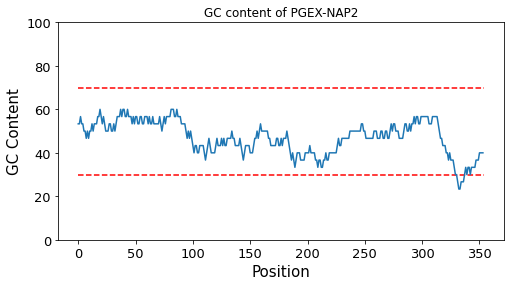

DNA name: PGEX-NAP2                                           
                     cub_h1 cpub_h1 cub_h2 cpub_h2 rep_nuc rho_T B_rho
Weights                 1.0     1.5    1.0     1.0     1.0  0.48  0.05

,Optimal Codon Seq
Similarity to ref_codon,0.770833
Effective number of codons,33.194129
GC,52.864583
GC3,59.375000


,e_coli,h_sapiens
CAI,0.647569,0.761944
CPB,0.123480,-0.001053


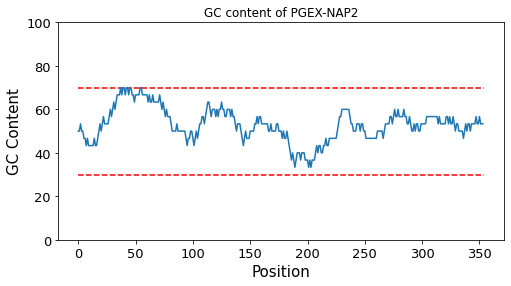

In [7]:
dp_metrics(name, cds[:-3], hosts, weight_params=weight_params, ref_codon=cds[:-3]) #
dp_metrics(name, opt_codon_seq, hosts, weight_params=weight_params, ref_codon=cds[:-3]) #